In [6]:
# MDO training + replay workflow for Pronghorn benchmarks (Runner), averaged over repeats
# - For each bench in DEFAULT_BENCHES:
#   * train MDO to /tmp/mdox_v3.bin using com.openfaas.function.Runner (1000 invocations)
#   * run cold and warm (MDO replay) for invocations=500, repeats=5
#   * save {bench}_mdo_raw.csv and {bench}_mdo_avg.csv to pronghorn-java/out
# - Also write all_mdo_raw.csv and all_mdo_avg.csv

from pathlib import Path
import subprocess, os, glob
import pandas as pd
import numpy as np

PRONG_ROOT = Path('/Users/georgezhou/personal/research/serverless-jit/bench/pronghorn-java')
RENAISSANCE_RUN_SH = PRONG_ROOT.parent / 'renaissance' / 'run.sh'
OUT_DIR = PRONG_ROOT / 'out'
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEFAULT_BENCHES = [
    'html-rendering',
    'matrix-multiplication',
    'simple-hash',
    'word-count',
]

MUTABILITY = 0.5
INVOCATIONS = 500
REPEATS = 5
TRAIN_INVOCATIONS = 1000
MDO_PATH = '/tmp/mdox_v3.bin'


def read_jdk25_path() -> str:
    return "/Users/georgezhou/personal/research/serverless-jit/jdk25u/build/macosx-aarch64-server-release/jdk/bin/java"


def ensure_install_dist(bench_dir: Path) -> None:
    libdir = bench_dir / 'build' / 'install' / 'function' / 'lib'
    if not libdir.exists() or not any(libdir.glob('*')):
        r = subprocess.run(['gradle', '-q', 'installDist'], cwd=str(bench_dir))
        if r.returncode != 0:
            raise RuntimeError(f'installDist failed in {bench_dir}')


def compute_classpath(bench_dir: Path) -> str:
    libdir = bench_dir / 'build' / 'install' / 'function' / 'lib'
    jars = sorted(glob.glob(str(libdir / '*')))
    if not jars:
        raise RuntimeError(f'No jars found in {libdir}; did installDist succeed?')
    return ':'.join(jars)


def run_runner(java: str, bench_dir: Path, cp: str, mutability: float, invocations: int, mdo_mode: str | None = None) -> list[int]:
    args = [java]
    if mdo_mode == 'train':
        args += [
            '-XX:+UnlockDiagnosticVMOptions',
            '-XX:+DumpMDOAtExit', f'-XX:MDOReplayDumpFile={MDO_PATH}',
            '-Xlog:compilation=info',
        ]
    elif mdo_mode == 'warm':
        args += [
            '-XX:+UnlockDiagnosticVMOptions',
            '-XX:+LoadMDOAtStartup', f'-XX:MDOReplayLoadFile={MDO_PATH}',
        ]
    args += ['-cp', cp, 'com.openfaas.function.Runner', str(mutability), str(invocations)]
    res = subprocess.run(args, cwd=str(bench_dir), capture_output=True, text=True)
    if res.returncode != 0:
        raise RuntimeError(
            f"Runner failed in {bench_dir.name} rc={res.returncode}\nSTDOUT:\n{res.stdout}\nSTDERR:\n{res.stderr}"
        )
    # Parse lines of microseconds
    lines = [ln.strip() for ln in (res.stdout or '').strip().splitlines() if ln.strip()]
    vals: list[int] = []
    for ln in lines:
        try:
            vals.append(int(ln))
        except ValueError:
            pass
    return vals


def run_bench_mdo(java: str, bench_name: str, repeats: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    bench_dir = PRONG_ROOT / bench_name
    ensure_install_dist(bench_dir)
    cp = compute_classpath(bench_dir)

    # Train MDO
    try:
        os.remove(MDO_PATH)
    except FileNotFoundError:
        pass
    _ = run_runner(java, bench_dir, cp, MUTABILITY, TRAIN_INVOCATIONS, mdo_mode='train')

    # Repeated runs
    cold_runs: list[list[int]] = []
    warm_runs: list[list[int]] = []
    for _r in range(repeats):
        cold_runs.append(run_runner(java, bench_dir, cp, MUTABILITY, INVOCATIONS, mdo_mode=None))
    for _r in range(repeats):
        warm_runs.append(run_runner(java, bench_dir, cp, MUTABILITY, INVOCATIONS, mdo_mode='warm'))

    # Normalize lengths
    min_len = min(min(len(x) for x in cold_runs), min(len(x) for x in warm_runs))

    # Raw long-form (µs)
    rows: list[dict] = []
    for r, series in enumerate(cold_runs):
        for i, v in enumerate(series[:min_len]):
            rows.append({'bench': bench_name, 'variant': 'cold', 'repeat': r, 'invocation': i + 1, 'us': v})
    for r, series in enumerate(warm_runs):
        for i, v in enumerate(series[:min_len]):
            rows.append({'bench': bench_name, 'variant': 'warm', 'repeat': r, 'invocation': i + 1, 'us': v})
    raw_df = pd.DataFrame(rows)

    # Averages (µs)
    cold_mat = np.array([x[:min_len] for x in cold_runs], dtype=float)
    warm_mat = np.array([x[:min_len] for x in warm_runs], dtype=float)
    avg_df = pd.DataFrame({
        'bench': bench_name,
        'invocation': np.arange(1, min_len + 1),
        'cold_mean_us': cold_mat.mean(axis=0),
        'warm_mean_us': warm_mat.mean(axis=0),
    })

    return raw_df, avg_df


# Execute across benches
java = read_jdk25_path()
print('Using java:', java)
all_raw: list[pd.DataFrame] = []
all_avg: list[pd.DataFrame] = []
for bench in DEFAULT_BENCHES:
    print(f"\n=== {bench} ===")
    raw_df, avg_df = run_bench_mdo(java, bench, REPEATS)
    all_raw.append(raw_df)
    all_avg.append(avg_df)
    raw_path = OUT_DIR / f"{bench}_mdo_raw.csv"
    avg_path = OUT_DIR / f"{bench}_mdo_avg.csv"
    raw_df.to_csv(raw_path, index=False)
    avg_df.to_csv(avg_path, index=False)
    print('Wrote', raw_path, 'and', avg_path)

all_raw_df = pd.concat(all_raw, ignore_index=True)
all_avg_df = pd.concat(all_avg, ignore_index=True)
all_raw_df.to_csv(OUT_DIR / 'all_mdo_raw.csv', index=False)
all_avg_df.to_csv(OUT_DIR / 'all_mdo_avg.csv', index=False)
print('Wrote', OUT_DIR / 'all_mdo_raw.csv', 'and', OUT_DIR / 'all_mdo_avg.csv')



Using java: /Users/georgezhou/personal/research/serverless-jit/jdk25u/build/macosx-aarch64-server-release/jdk/bin/java

=== html-rendering ===
Wrote /Users/georgezhou/personal/research/serverless-jit/bench/pronghorn-java/out/html-rendering_mdo_raw.csv and /Users/georgezhou/personal/research/serverless-jit/bench/pronghorn-java/out/html-rendering_mdo_avg.csv

=== matrix-multiplication ===
Wrote /Users/georgezhou/personal/research/serverless-jit/bench/pronghorn-java/out/matrix-multiplication_mdo_raw.csv and /Users/georgezhou/personal/research/serverless-jit/bench/pronghorn-java/out/matrix-multiplication_mdo_avg.csv

=== simple-hash ===
Wrote /Users/georgezhou/personal/research/serverless-jit/bench/pronghorn-java/out/simple-hash_mdo_raw.csv and /Users/georgezhou/personal/research/serverless-jit/bench/pronghorn-java/out/simple-hash_mdo_avg.csv

=== word-count ===
Wrote /Users/georgezhou/personal/research/serverless-jit/bench/pronghorn-java/out/word-count_mdo_raw.csv and /Users/georgezhou/pe

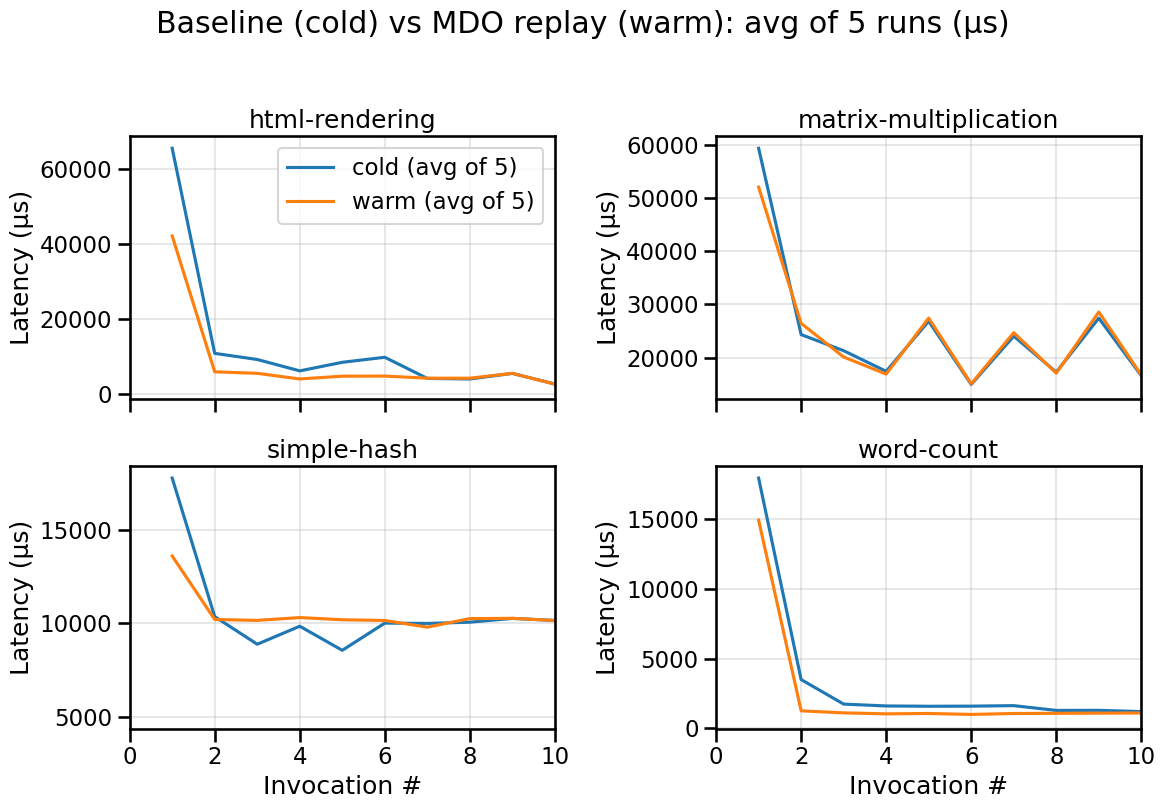

In [ ]:
# Plot averaged speedup (warm/cold) across Pronghorn benchmarks (uses all_mdo_avg.csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

all_avg_path = OUT_DIR / 'all_mdo_avg.csv'
if not all_avg_path.exists():
    raise FileNotFoundError(f'Missing averaged CSV: {all_avg_path}. Run the first cell to generate it.')

all_avg = pd.read_csv(all_avg_path)
benches = list(all_avg['bench'].unique())
order = [b for b in ['html-rendering','matrix-multiplication','simple-hash','word-count'] if b in benches] or benches

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()
for ax, bench in zip(axes, order):
    sub = all_avg[all_avg['bench'] == bench]
    ratio = sub['warm_mean_us'] / sub['cold_mean_us']
    ax.plot(sub['invocation'], ratio, label='speedup (warm / cold)')
    ax.set_title(bench)
    ax.set_ylabel('Speedup (warm / cold)')
    ax.grid(True, alpha=0.3)

axes[-2].set_xlabel('Invocation #')
axes[-1].set_xlabel('Invocation #')
axes[0].legend(loc='upper right')
plt.xlim(0, 10)
plt.suptitle('MDO replay speedup over baseline (warm / cold): avg of 5', y=1.02)
plt.tight_layout()
plt.show()


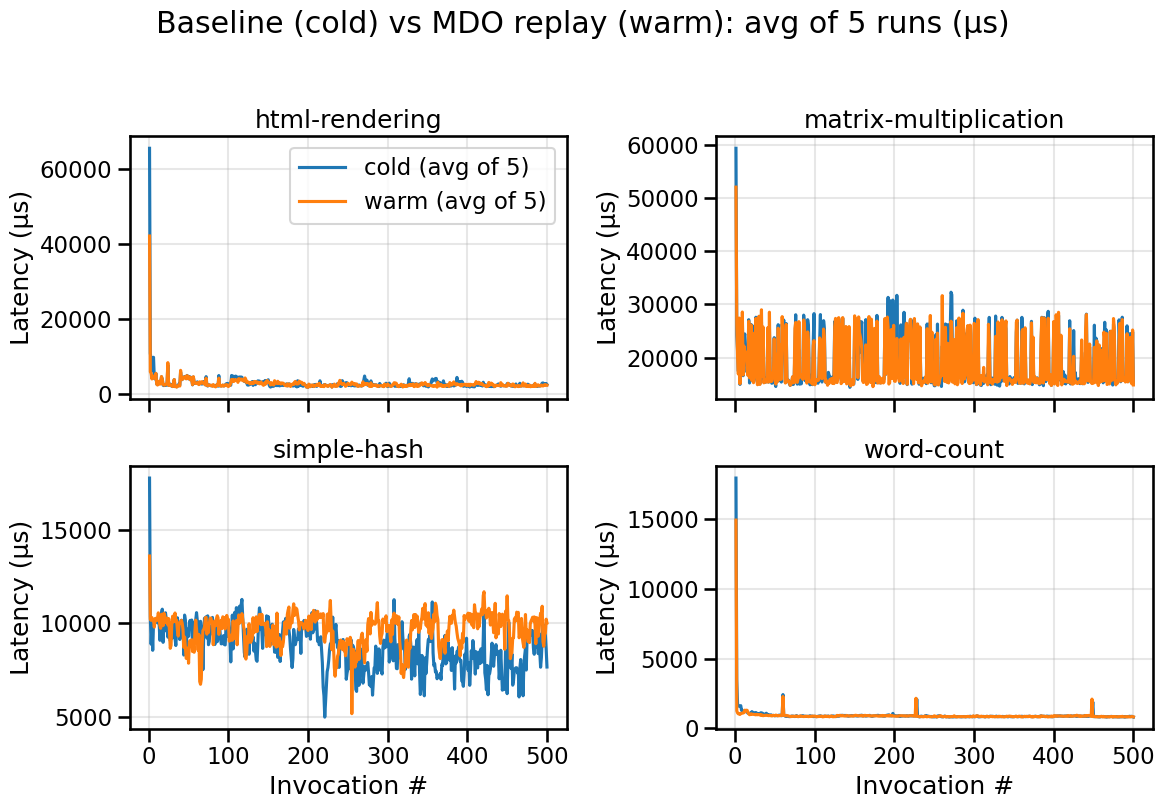

In [ ]:
# Plot averaged speedup (warm/cold) across Pronghorn benchmarks (uses all_mdo_avg.csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

all_avg_path = OUT_DIR / 'all_mdo_avg.csv'
if not all_avg_path.exists():
    raise FileNotFoundError(f'Missing averaged CSV: {all_avg_path}. Run the first cell to generate it.')

all_avg = pd.read_csv(all_avg_path)
benches = list(all_avg['bench'].unique())
order = [b for b in ['html-rendering','matrix-multiplication','simple-hash','word-count'] if b in benches] or benches

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()
for ax, bench in zip(axes, order):
    sub = all_avg[all_avg['bench'] == bench]
    ratio = sub['warm_mean_us'] / sub['cold_mean_us']
    ax.plot(sub['invocation'], ratio, label='speedup (warm / cold)')
    ax.set_title(bench)
    ax.set_ylabel('Speedup (warm / cold)')
    ax.grid(True, alpha=0.3)
axes[-2].set_xlabel('Invocation #')
axes[-1].set_xlabel('Invocation #')
axes[0].legend(loc='upper right')
plt.suptitle('MDO replay speedup over baseline (warm / cold): avg of 5', y=1.02)
plt.tight_layout()
plt.show()
